decision tree iwthin cluster
-> analyse feature distribution

breakdown how clusters are formed, see if it matches business req

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
### https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [5]:
df = pd.read_csv('../txn_data.csv',encoding="ISO-8859-1",
                         parse_dates=['InvoiceDate'])
df_original = df.copy()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Check null values

In [6]:
round(df.isnull().sum()/len(df) * 100, 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [7]:
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

In [8]:
round(df.isnull().sum()/len(df) * 100, 2)

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

## Check duplicates

In [9]:
print(f"No. of duplicated entries: {df.duplicated().sum()}")

No. of duplicated entries: 5225


In [10]:
df.drop_duplicates(inplace=True)

## Calculate spending for each transaction

In [11]:
df['Spending'] = df['Quantity'] * df['UnitPrice']
df['Spending']

0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
541904    10.20
541905    12.60
541906    16.60
541907    16.60
541908    14.85
Name: Spending, Length: 401604, dtype: float64

# EDA

## How many orders made by customers per country?

In [12]:
df.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count().sort_values(by = 'InvoiceNo', ascending = False).head()

,CustomerID,Country,InvoiceNo
4050,17841.0,United Kingdom,7812
1903,14911.0,EIRE,5898
1308,14096.0,United Kingdom,5128
338,12748.0,United Kingdom,4459
1682,14606.0,United Kingdom,2759


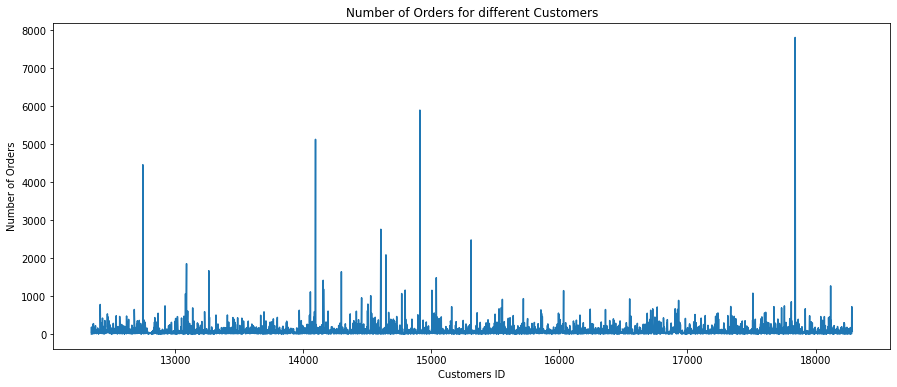

In [13]:
orders = df.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()

plt.subplots(figsize=(15,6))
plt.plot(orders.CustomerID, orders.InvoiceNo)
plt.xlabel('Customers ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for different Customers')
plt.show()

In [14]:
orders.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [15]:
orders.sort_values(by='InvoiceNo', ascending=False).head()

,CustomerID,InvoiceNo
4042,17841.0,7812
1895,14911.0,5898
1300,14096.0,5128
330,12748.0,4459
1674,14606.0,2759


In [16]:
df[df['InvoiceNo'].str.contains('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spending
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-1.25


In [17]:
df[(df['StockCode'] == '23144') & (~df['InvoiceNo'].str.contains('C'))].sum()

C:\Users\peh_s\AppData\Local\Temp\ipykernel_20756\895027496.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[(df['StockCode'] == '23144') & (~df['InvoiceNo'].str.contains('C'))].sum()


InvoiceNo      5508235509555509945510595511605511615511995512...
StockCode      2314423144231442314423144231442314423144231442...
Description    ZINC T-LIGHT HOLDER STARS SMALLZINC T-LIGHT HO...
Quantity                                                    4894
UnitPrice                                                  199.2
CustomerID                                             3609454.0
Country        United KingdomUnited KingdomUnited KingdomUnit...
Spending                                                 3879.98
dtype: object

In [18]:
df[df['StockCode'] == '23144'].sum()

C:\Users\peh_s\AppData\Local\Temp\ipykernel_20756\3788974131.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[df['StockCode'] == '23144'].sum()


InvoiceNo      5508235509555509945510595511605511615511995512...
StockCode      2314423144231442314423144231442314423144231442...
Description    ZINC T-LIGHT HOLDER STARS SMALLZINC T-LIGHT HO...
Quantity                                                    4850
UnitPrice                                                 201.69
CustomerID                                             3658214.0
Country        United KingdomUnited KingdomUnited KingdomUnit...
Spending                                                 3843.46
dtype: object

In [19]:
df[df['Description'].str.contains('PAPER CRAFT')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spending
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.6
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,-168469.6


In [21]:
list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [22]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df[df['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


In [23]:
# df_cleaned = df.copy(deep = True)
# df_cleaned['QuantityCanceled'] = 0

# no_counterpart = []
# with_counterpart = []
# for index, col in  df.iterrows():
#     if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
#     df_test = df[(df['CustomerID'] == col['CustomerID']) &
#                          (df['StockCode']  == col['StockCode']) & 
#                          (df['InvoiceDate'] < col['InvoiceDate']) & 
#                          (df['Quantity']   > 0)].copy()
#     #_________________________________
#     # Cancelation WITHOUT counterpart
#     if (df_test.shape[0] == 0): 
#         no_counterpart.append(index)
#     #________________________________
#     # Cancelation WITH a counterpart
#     elif (df_test.shape[0] == 1): 
#         index_order = df_test.index[0]
#         df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
#         with_counterpart.append(index)        
#     #______________________________________________________________
#     # Various counterparts exist in orders: we delete the last one
#     elif (df_test.shape[0] > 1): 
#         df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
#         for ind, val in df_test.iterrows():
#             if val['Quantity'] < -col['Quantity']: continue
#             df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
#             with_counterpart.append(index) 
#             break           

<AxesSubplot:xlabel='CustomerID'>

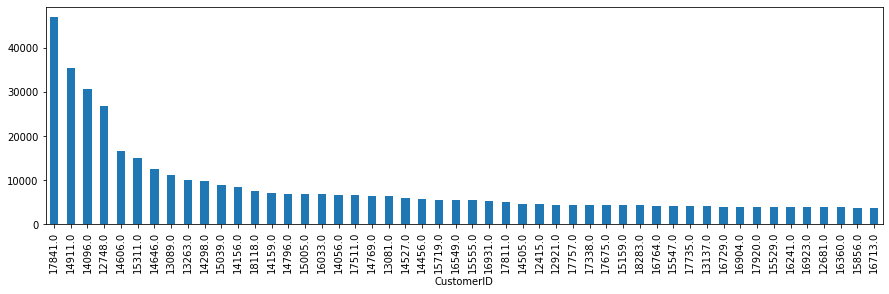

In [24]:
fig, ax = plt.subplots(figsize=(15,4))
grouped = df.groupby("CustomerID")['InvoiceNo'].sum()
grouped_counts = grouped.apply(lambda x: len(x)).sort_values(ascending=False)
grouped_counts.head(50).plot.bar(ax=ax)

Count no. of txns corresponding to canceled orders

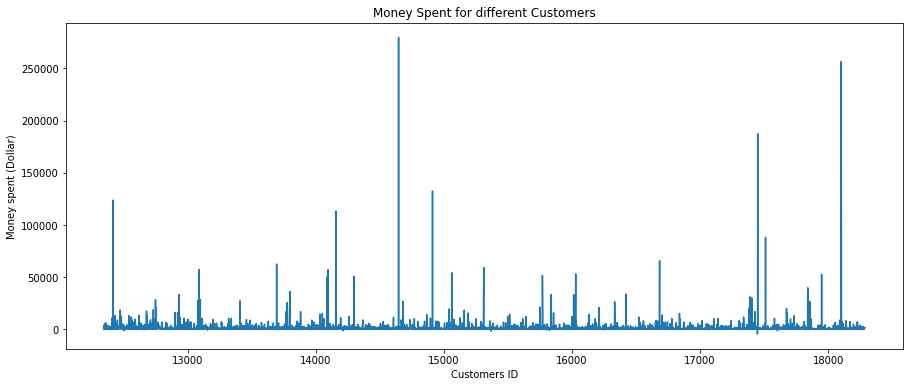

In [25]:
money_spent = df.groupby(by=['CustomerID','Country'], as_index=False)['Spending'].sum()

plt.subplots(figsize=(15,6))
plt.plot(money_spent.CustomerID, money_spent.Spending)
plt.xlabel('Customers ID')
plt.ylabel('Money spent (Dollar)')
plt.title('Money Spent for different Customers')
plt.show()

In [26]:
print('The TOP 5 customers with highest money spent...')
money_spent.sort_values(by='Spending', ascending=False).head()

The TOP 5 customers with highest money spent...


,CustomerID,Country,Spending
1711,14646.0,Netherlands,279489.02
4241,18102.0,United Kingdom,256438.49
3766,17450.0,United Kingdom,187322.17
1903,14911.0,EIRE,132458.73
57,12415.0,Australia,123725.45


In [27]:
# # Let's look at the list of txns
# df_initial.sort_values('CustomerID')[:5]

In [28]:
# df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
#                                                    'StockCode','Description','UnitPrice']]
# for index, col in  df_check.iterrows():
#     if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
#                 & (df_initial['Description'] == col[2])].shape[0] == 0: 
#         print(df_check.loc[index])
#         print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
#         break

In [29]:
# df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
#                                  ['CustomerID','Quantity','StockCode',
#                                   'Description','UnitPrice']]

# for index, col in  df_check.iterrows():
#     if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
#                 & (df_initial['Description'] == col[2])].shape[0] == 0: 
#         print(index, df_check.loc[index])
#         print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
#         break

# Seasonality comparison

In [30]:
def combine_seasonal_cols(input_df, seasonal_model_results):
    """Adds inplace new seasonal cols to df given seasonal results

    Args:
        input_df (pandas dataframe)
        seasonal_model_results (statsmodels DecomposeResult object)
    """
    # Add results to original df
    input_df['observed'] = seasonal_model_results.observed
    input_df['residual'] = seasonal_model_results.resid
    input_df['seasonal'] = seasonal_model_results.seasonal
    input_df['trend'] = seasonal_model_results.trend

In [31]:
seasons = df.groupby(['Description', df['InvoiceDate'].dt.date]).sum()
seasons = seasons[['Spending']]

In [32]:
seasons.head()

Spending
Description                    InvoiceDate          
 4 PURPLE FLOCK DINNER CANDLES 2010-12-01       5.10
                               2010-12-05      30.60
                               2011-01-05       2.55
                               2011-01-26       2.55
                               2011-02-28       2.55

In [33]:
product_names = seasons.index.get_level_values(0).unique()
product_names

Index([' 4 PURPLE FLOCK DINNER CANDLES', ' 50'S CHRISTMAS GIFT BAG LARGE',
       ' DOLLY GIRL BEAKER', ' I LOVE LONDON MINI BACKPACK',
       ' I LOVE LONDON MINI RUCKSACK', ' NINE DRAWER OFFICE TIDY',
       ' OVAL WALL MIRROR DIAMANTE ', ' RED SPOT GIFT BAG LARGE',
       ' SET 2 TEA TOWELS I LOVE LONDON ', ' SPACEBOY BABY GIFT SET',
       ...
       'ZINC STAR T-LIGHT HOLDER ', 'ZINC SWEETHEART SOAP DISH',
       'ZINC SWEETHEART WIRE LETTER RACK', 'ZINC T-LIGHT HOLDER STAR LARGE',
       'ZINC T-LIGHT HOLDER STARS LARGE', 'ZINC T-LIGHT HOLDER STARS SMALL',
       'ZINC TOP  2 DOOR WOODEN SHELF ', 'ZINC WILLIE WINKIE  CANDLE STICK',
       'ZINC WIRE KITCHEN ORGANISER', 'ZINC WIRE SWEETHEART LETTER TRAY'],
      dtype='object', name='Description', length=3896)

In [34]:
sd = seasonal_decompose(seasons, period=12)
combine_seasonal_cols(seasons, sd)

# Article Flow

**Highlight importance of identifying sales seasonality for a business right at the beginning of the article**
Talk about trying to identify individual seasonality of products, but realize that sales data on an individual product level is sparse, therefore used NLP to classify products based on their product description (BERTopic)

In [35]:
seasons.tail(n = 20)

Spending  observed   residual  \
Description                      InvoiceDate                                  
ZINC WIRE KITCHEN ORGANISER      2011-12-08      35.55     35.55  18.147037   
                                 2011-12-09      15.80     15.80  -2.694788   
ZINC WIRE SWEETHEART LETTER TRAY 2011-04-21       3.75      3.75 -15.973358   
                                 2011-04-26      15.00     15.00  -3.400531   
                                 2011-04-28      78.96     78.96  62.464610   
                                 2011-05-19      15.00     15.00  -2.433093   
                                 2011-05-31       7.50      7.50 -10.486177   
                                 2011-06-02      23.03     23.03   4.642380   
                                 2011-06-20       3.75      3.75 -13.229460   
                                 2011-07-14      15.00     15.00  -2.310810   
                                 2011-08-18       3.75      3.75  -9.592074   
                                 2011-09-04       7.50      7.50  -4.857903   
                                 2011-10-10      22.50     22.50  13.214120   
                                 2011-10-11       3.75      3.75  -5.783538   
                                 2011-10-27       3.75      3.75        NaN   
                                 2011-11-18      18.75     18.75        NaN   
                                 2011-11-23       7.50      7.50        NaN   
                                 2011-11-24       3.75      3.75        NaN   
                                 2011-11-30       3.75      3.75        NaN   
                                 2011-12-07      16.25     16.25        NaN   

                                              seasonal      trend  
Description                      InvoiceDate                       
ZINC WIRE KITCHEN ORGANISER      2011-12-08  -0.602037  18.005000  
                                 2011-12-09   0.084371  18.410417  
ZINC WIRE SWEETHEART LETTER TRAY 2011-04-21   1.063775  18.659583  
                                 2011-04-26  -0.173636  18.574167  
                                 2011-04-28  -2.262110  18.757500  
                                 2011-05-19  -1.299407  18.732500  
                                 2011-05-31  -0.185907  18.172083  
                                 2011-06-02   1.261370  17.126250  
                                 2011-06-20   0.355293  16.624167  
                                 2011-07-14   0.530394  16.780417  
                                 2011-08-18  -0.617093  13.959167  
                                 2011-09-04   1.844986  10.512917  
                                 2011-10-10  -0.602037   9.887917  
                                 2011-10-11   0.084371   9.449167  
                                 2011-10-27   1.063775        NaN  
                                 2011-11-18  -0.173636        NaN  
                                 2011-11-23  -2.262110        NaN  
                                 2011-11-24  -1.299407        NaN  
                                 2011-11-30  -0.185907        NaN  
                                 2011-12-07   1.261370        NaN

In [36]:
seasons['residual']

Description                       InvoiceDate
 4 PURPLE FLOCK DINNER CANDLES    2010-12-01    NaN
                                  2010-12-05    NaN
                                  2011-01-05    NaN
                                  2011-01-26    NaN
                                  2011-02-28    NaN
                                                 ..
ZINC WIRE SWEETHEART LETTER TRAY  2011-11-18    NaN
                                  2011-11-23    NaN
                                  2011-11-24    NaN
                                  2011-11-30    NaN
                                  2011-12-07    NaN
Name: residual, Length: 225826, dtype: float64

# RFM Analysis

In [37]:
today_date = dt.datetime(2011, 12, 1)

In [38]:
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'InvoiceNo'    : lambda InvoiceNo: InvoiceNo.nunique(),
                                     'Spending' : lambda Spending: Spending.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']

In [39]:
#more days since last purchase 1 (very bad) ; those with fewer days 5 (very good).
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

#5 (very good) for those with high purchasing frequency; the ones that were less as 1 (very bad).
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

#5 (very good) for those with a high purchase price;  the fewer purchase price as 1 (very bad).
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

#we'll not include monetory_score.
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

In [40]:
rfm

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
CustomerID,,,,,,,
12346.0,316,2,0.00,1,2,1,12
12347.0,-7,7,4310.00,5,4,5,54
12348.0,66,4,1797.24,2,3,4,23
12349.0,9,1,1757.55,4,1,4,41
12350.0,301,1,334.40,1,1,2,11
...,...,...,...,...,...,...,...
18280.0,268,1,180.60,1,2,1,12
18281.0,171,1,80.82,1,2,1,12
18282.0,-2,3,176.60,5,3,1,53


In [41]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.reset_index(inplace=True)
rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346.0,316,2,0.00,1,2,1,12,hibernating
1,12347.0,-7,7,4310.00,5,4,5,54,champions
2,12348.0,66,4,1797.24,2,3,4,23,at_Risk
3,12349.0,9,1,1757.55,4,1,4,41,promising
4,12350.0,301,1,334.40,1,1,2,11,hibernating


In [43]:
rfm_segmented = rfm[['CustomerID', 'RFM_SCORE', 'segment']]

In [44]:
merged_df = pd.merge(df, rfm_segmented, on='CustomerID')

In [46]:
merged_df.to_csv('intermediary_datasets/sales_analysis.csv', index= False)